# Discrete actions

In this notebook, instead of a continuos acceleration between -1 and 1 like in [Dummy-Continuos](./Dummy-Continuos.ipynb), the agent  learns a discrete policy, which can:
- keep the same speed
- brake by 0.1 m/s^2
- accelerate by 0.1 m/s^2

We try 2 different discretization of the action space.
We use StableBaseline3 PPO algorithm which support multi-discrete and multi-binary action spaces with the same configuration as in [Dummy-Continuos](./Dummy-Continuos.ipynb).

You can skip training and instead load the last trained policy by changing the flag below.

In [1]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

## Multi-binary action space

We configure the training environment with `start_in_opposite_sides=True` because we noted [Dummy-Continuos](./Dummy-Continuos.ipynb) that PPO does not learn well unless it is trained in an scenario where the agents starts from opposing side.

In [5]:
from navground import core, sim
from navground.learning import ControlActionConfig, DefaultObservationConfig
from navground.learning.config import BinaryControlActionConfig
from navground.learning.examples.pad import get_env, marker, neighbor
from stable_baselines3.common.monitor import Monitor

name = "DummyMultiBinary"
action_mb = BinaryControlActionConfig(use_acceleration_action=True, max_acceleration=0.1, fix_orientation=True)
observation = DefaultObservationConfig(flat=False, include_velocity=True, include_target_direction=False)
sensors = [marker(), neighbor(max_speed=0)]
train_env_mb = get_env(action=action_mb, observation=observation, 
                       sensors=sensors, start_in_opposite_sides=True, multi_agent=False)
test_env_mb = Monitor(get_env(action=action_mb, observation=observation, 
                      sensors=sensors, start_in_opposite_sides=True, multi_agent=False))

Let us start with an action space composed of two binary values. The first control braking, the second acceleration. When both are equal, the agent keeps the same speed.

In [6]:
train_env_mb.action_space

MultiBinary(2)

When the first bit is 1, the agent brake. When the second is 1, the agent accelerates. When both values are equal, the agent keep the same speed.

In [7]:
%%skip_if $training

import pathlib, os
from stable_baselines3 import PPO

log_mb = max(pathlib.Path(f'logs/{name}/PPO').glob('*'), key=os.path.getmtime)

In [9]:
%%run_if $training

from stable_baselines3 import PPO
from datetime import datetime as dt
from stable_baselines3.common.logger import configure
from navground.learning.utils.sb3 import callbacks
from navground.learning.scenarios.pad import render_kwargs

model_mb = PPO("MultiInputPolicy", train_env_mb, verbose=0, n_steps=2048 * 3)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
log_mb = f"logs/{name}/PPO/{stamp}"
model_mb.set_logger(configure(log_mb, ["csv", "tensorboard"]))
cbs = callbacks(venv=test_env_mb, best_model_save_path=log_mb, 
                eval_freq=2048 * 12, export_to_onnx=True, **render_kwargs())
log_mb

'logs/DummyMultiBinary/PPO/20250521_085449'

In [10]:
%%run_if $training

model_mb.learn(total_timesteps=500_000, reset_num_timesteps=False, log_interval=1, callback=cbs)

  0%|          | 0/500000 [00:00<?, ?it/s]

In [11]:
from stable_baselines3.common.evaluation import evaluate_policy

best_model_mb = PPO.load(f'{log_mb}/best_model')
evaluate_policy(best_model_mb.policy, test_env_mb, n_eval_episodes=30)

(-44.54047640000001, 25.81250881777759)

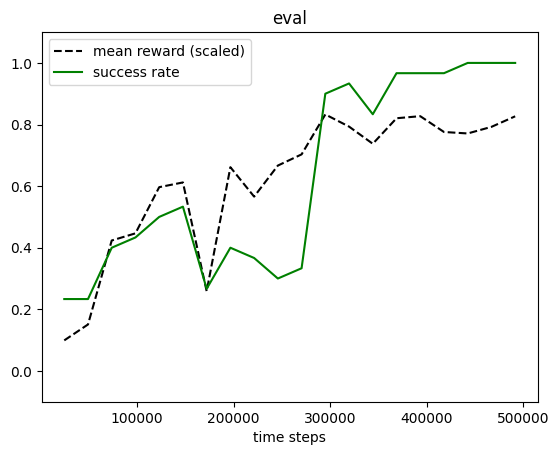

In [13]:
from navground.learning.utils.sb3 import plot_eval_logs

plot_eval_logs(log_mb, reward_low=-200, reward_high=0, success=True)

Let us verify that the policy does indeed produce discrete accelerations.

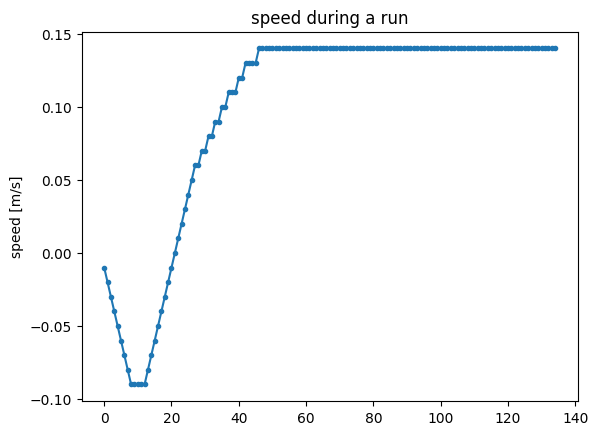

In [15]:
from navground.learning.evaluation.experiment import make_experiment_with_env
from matplotlib import pyplot as plt

exp = make_experiment_with_env(test_env_mb, policy=best_model_mb.policy)
exp.record_config.twist = True
run = exp.run_once(seed=3)
plt.plot(run.twists[:, 0, 0], '.-')
plt.title('speed during a run')
plt.ylabel('speed [m/s]');

In [18]:
from navground.learning.evaluation.video import display_episode_video
from navground.learning.scenarios.pad import render_kwargs

display_episode_video(test_env_mb, policy=best_model_mb.policy, factor=4, seed=3, **render_kwargs())

In [21]:
from navground.learning.evaluation.video import record_episode_video

record_episode_video(test_env_mb, policy=best_model_mb.policy, 
                     path=f'../videos/{name}.mp4', seed=1, **render_kwargs())

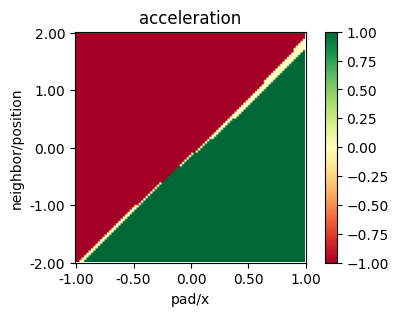

In [25]:
from navground.learning.utils.plot import plot_policy

plot_policy(best_model_mb.policy, 
            variable={'pad/x': (-1, 1), 'neighbor/position': (-2, 2)},
            fix={'ego_velocity': 0.0}, 
            actions={0: 'acceleration'}, width=5, height=3)

## Discrete action space

We switch to a single discrete space with 3 possible values:
- 0: it brakes
- 1: it keeps the same speed
- 2: it accelerates

In [27]:
from navground.learning.config import DiscreteControlActionConfig

name = "DummyDiscrete"
action_discrete = DiscreteControlActionConfig(use_acceleration_action=True, max_acceleration=0.1, fix_orientation=True)
train_env_discrete = get_env(action=action_discrete, observation=observation,
                             sensors=sensors, start_in_opposite_sides=True, multi_agent=False)
test_env_discrete = Monitor(get_env(action=action_discrete, observation=observation,
                            sensors=sensors, start_in_opposite_sides=True, multi_agent=False))

In [28]:
train_env_discrete.action_space

Discrete(3)

In [29]:
%%skip_if $training

log_discrete = max(pathlib.Path(f'logs/{name}/PPO').glob('*'), key=os.path.getmtime)

In [31]:
%%run_if $training

model_discrete = PPO("MultiInputPolicy", train_env_discrete, verbose=0, n_steps=2048 * 3)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
log_discrete = f"logs/{name}/PPO/{stamp}"
model_discrete.set_logger(configure(log_discrete, ["csv", "tensorboard"]))
cbs = callbacks(venv=test_env_discrete, best_model_save_path=log_discrete, 
                eval_freq=2048 * 12, export_to_onnx=True, **render_kwargs())

In [32]:
%%run_if $training

model_discrete.learn(total_timesteps=500_000, reset_num_timesteps=False, 
                     log_interval=1, callback=cbs)

  0%|          | 0/500000 [00:00<?, ?it/s]

In [33]:
best_model_discrete = PPO.load(f'{log_discrete}/best_model')
evaluate_policy(best_model_discrete.policy, test_env_discrete, n_eval_episodes=30)

(-42.447618566666655, 24.114324592916077)

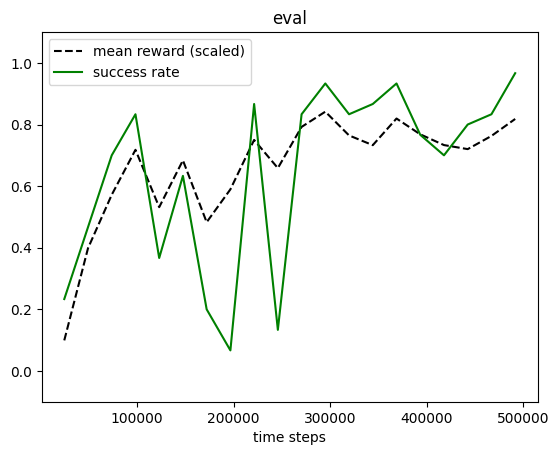

In [34]:
plot_eval_logs(log_discrete, reward_low=-200, reward_high=0, success=True)

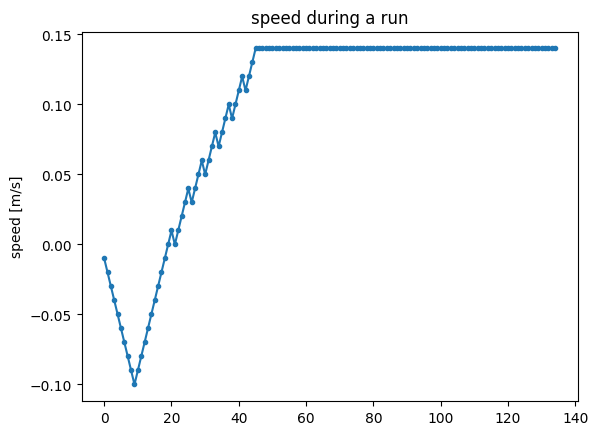

In [35]:
exp = make_experiment_with_env(test_env_discrete, policy=best_model_discrete.policy)
exp.record_config.twist = True
run = exp.run_once(seed=3)
plt.plot(run.twists[:, 0, 0], '.-')
plt.title('speed during a run')
plt.ylabel('speed [m/s]');

In [36]:
display_episode_video(test_env_discrete, policy=best_model_discrete.policy, 
                      factor=4, seed=3, **render_kwargs())

In [37]:
record_episode_video(test_env_discrete, policy=best_model_discrete.policy, 
                     path=f'../videos/{name}.mp4', seed=1, **render_kwargs())

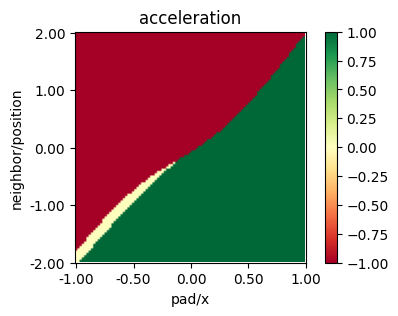

In [38]:
plot_policy(best_model_discrete.policy, 
            variable={'pad/x': (-1, 1), 'neighbor/position': (-2, 2)},
            fix={'ego_velocity': 0.0}, 
            actions={0: 'acceleration'}, width=5, height=3)